# Impor Library

In [ ]:
import os
import zipfile
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
from pathlib import Path

# Impor Dataset

In [ ]:
zip_path = "/content/img_align_celeba.zip"
extract_path = "/content/celeba"

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_path)

print("Done!")

Done!


# Konfigurasi Awal

In [ ]:
BATCH_SIZE = 64
LATENT_DIM = 64
LR = 1e-3
EPOCHS = 100
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SAMPLES_DIR = "/content/vae_samples"
CHECKPOINT_PATH = "/content/vae_checkpoint.pth"
SEED = 42

# Device Recognize

In [ ]:
random.seed(SEED)
torch.manual_seed(SEED)
if DEVICE == "cuda":
    torch.cuda.manual_seed_all(SEED)

os.makedirs(SAMPLES_DIR, exist_ok=True)

print(f"Device: {DEVICE}")

Device: cuda


# Transform Data

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),   # gives range [0,1]
])

dataset = datasets.ImageFolder(root=extract_path, transform=transform)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

print(f"Dataset size: {len(dataset)} images. Batches: {len(loader)}")

Dataset size: 200 images. Batches: 4


# Arsitektur VAE dengan Residual Blocks

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        return F.relu(x + self.block(x))

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.down = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),   # 128 → 64
            nn.ReLU(True),
            ResidualBlock(32),

            nn.Conv2d(32, 64, 4, 2, 1), # 64 → 32
            nn.ReLU(True),
            ResidualBlock(64),

            nn.Conv2d(64, 128, 4, 2, 1), # 32 → 16
            nn.ReLU(True),
            ResidualBlock(128),

            nn.Conv2d(128, 256, 4, 2, 1), # 16 → 8
            nn.ReLU(True),
            ResidualBlock(256),

            nn.Conv2d(256, 512, 4, 2, 1), # 8 → 4
            nn.ReLU(True),
            ResidualBlock(512),
        )

        # Detect flatten size
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 128, 128)
            out = self.down(dummy)
            self.flatten_dim = out.numel()

        self.fc_mu = nn.Linear(self.flatten_dim, LATENT_DIM)
        self.fc_logvar = nn.Linear(self.flatten_dim, LATENT_DIM)

    def forward(self, x):
        x = self.down(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, flatten_dim):
        super().__init__()

        self.init_spatial = 4
        self.init_channels = flatten_dim // (self.init_spatial * self.init_spatial)

        self.fc = nn.Linear(LATENT_DIM, self.init_channels * 4 * 4)

        self.up = nn.Sequential(
            nn.ConvTranspose2d(self.init_channels, 256, 4, 2, 1),
            nn.ReLU(True),
            ResidualBlock(256),

            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.ReLU(True),
            ResidualBlock(128),

            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(True),
            ResidualBlock(64),

            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(True),
            ResidualBlock(32),

            nn.ConvTranspose2d(32, 3, 4, 2, 1),
            nn.Sigmoid()
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, self.init_channels, 4, 4)
        return self.up(x)

class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder(self.encoder.flatten_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar

# VAE Loss Function

In [ ]:
def vae_loss(recon, x, mu, logvar):
    # Reconstruction loss (sum over elements)
    recon_loss = F.mse_loss(recon, x, reduction="sum")
    # KL divergence
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # return average per-batch (per-image)
    batch_size = x.size(0)
    return (recon_loss + kl) / batch_size

# Inisialisasi Model & Optimizer

In [ ]:
vae = VAE().to(DEVICE)
optimizer = torch.optim.Adam(vae.parameters(), lr=LR)

# Print model info for sanity
print(f"Encoder flatten dim: {vae.encoder.flatten_dim}")
print(f"Decoder init channels: {vae.decoder.init_channels}, init spatial: {vae.decoder.init_spatial}")

Encoder flatten dim: 8192
Decoder init channels: 512, init spatial: 4


# Training

In [ ]:
loss_history = []

vae.train()
for epoch in range(1, EPOCHS + 1):
    total_loss = 0.0

    for batch_idx, (images, _) in enumerate(loader):
        images = images.to(DEVICE)

        recon, mu, logvar = vae(images)
        loss = vae_loss(recon, images, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)

        if batch_idx % 200 == 0:
            print(f"Epoch {epoch} | Batch {batch_idx}/{len(loader)} | Batch loss: {loss.item():.4f}")

    avg_loss = total_loss / len(dataset)
    print(f"=== Epoch {epoch}/{EPOCHS} finished. Avg loss per image: {avg_loss:.4f} ===")

    # SIMPAN LOSS
    loss_history.append(avg_loss)

    # Save checkpoint
    torch.save({
        'epoch': epoch,
        'model_state_dict': vae.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'avg_loss': avg_loss
    }, CHECKPOINT_PATH)

    print(f"Checkpoint saved to {CHECKPOINT_PATH}")

    # Generate samples
    vae.eval()
    with torch.no_grad():
        z = torch.randn(16, LATENT_DIM).to(DEVICE)
        samples = vae.decoder(z)
        sample_path = os.path.join(SAMPLES_DIR, f"samples_epoch_{epoch}.png")
        save_reconstructed_grid(samples.cpu(), sample_path, nrow=4)

    vae.train()

Epoch 1 | Batch 0/4 | Batch loss: 301.7249
=== Epoch 1/100 finished. Avg loss per image: 288.4162 ===
Checkpoint saved to /content/vae_checkpoint.pth
Saved: /content/vae_samples/samples_epoch_1.png
Epoch 2 | Batch 0/4 | Batch loss: 292.4159
=== Epoch 2/100 finished. Avg loss per image: 286.8770 ===
Checkpoint saved to /content/vae_checkpoint.pth
Saved: /content/vae_samples/samples_epoch_2.png
Epoch 3 | Batch 0/4 | Batch loss: 297.9828
=== Epoch 3/100 finished. Avg loss per image: 284.7455 ===
Checkpoint saved to /content/vae_checkpoint.pth
Saved: /content/vae_samples/samples_epoch_3.png
Epoch 4 | Batch 0/4 | Batch loss: 286.0143
=== Epoch 4/100 finished. Avg loss per image: 283.0716 ===
Checkpoint saved to /content/vae_checkpoint.pth
Saved: /content/vae_samples/samples_epoch_4.png
Epoch 5 | Batch 0/4 | Batch loss: 284.4142
=== Epoch 5/100 finished. Avg loss per image: 278.6608 ===
Checkpoint saved to /content/vae_checkpoint.pth
Saved: /content/vae_samples/samples_epoch_5.png
Epoch 6 | 

# Grafik Train Loss

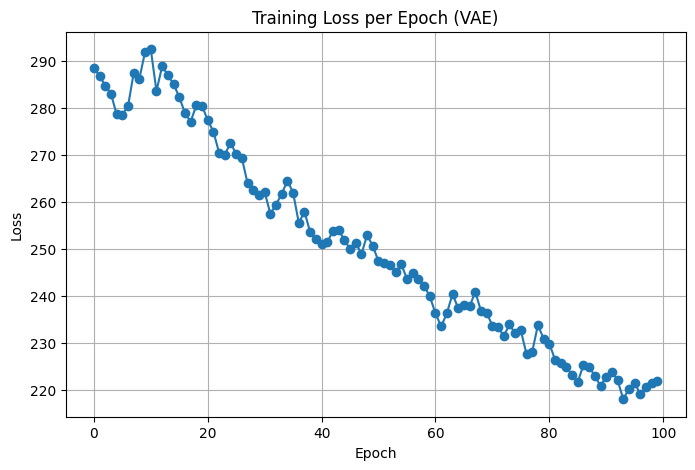

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(loss_history, marker='o')
plt.title("Training Loss per Epoch (VAE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Visualization

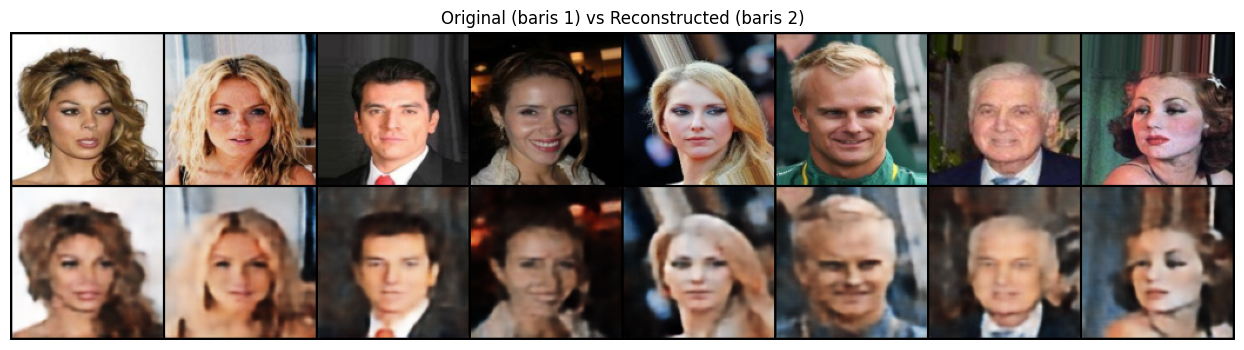

In [ ]:
from torchvision.utils import make_grid

vae.eval()

# ambil 8 sample dari dataset
images, _ = next(iter(loader))
images = images[:8].to(DEVICE)

with torch.no_grad():
    recon, _, _ = vae(images)

# convert grid
grid = make_grid(torch.cat([images.cpu(), recon.cpu()], dim=0), nrow=8)

plt.figure(figsize=(16,4))
plt.title("Original (baris 1) vs Reconstructed (baris 2)")
plt.imshow(grid.permute(1,2,0))
plt.axis("off")
plt.show()

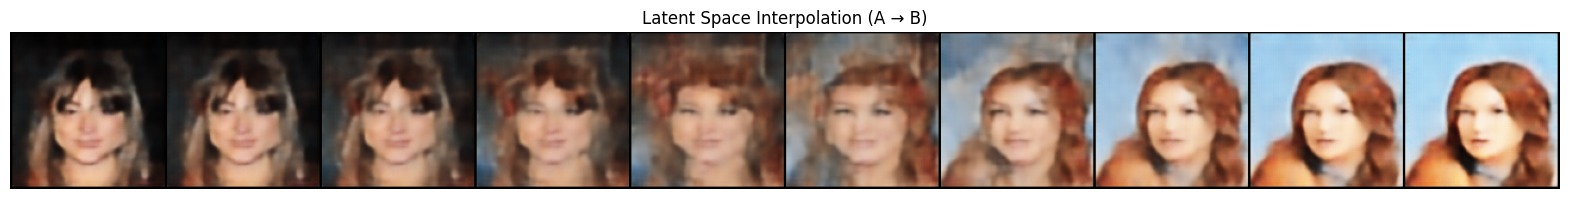

In [ ]:
# ambil 2 gambar dari dataset
img_batch, _ = next(iter(loader))
A = img_batch[0].unsqueeze(0).to(DEVICE)
B = img_batch[1].unsqueeze(0).to(DEVICE)

vae.eval()
with torch.no_grad():
    muA, logA = vae.encoder(A)
    muB, logB = vae.encoder(B)

    zA = vae.reparameterize(muA, logA)
    zB = vae.reparameterize(muB, logB)

# buat 10 langkah interpolasi
steps = 10
alphas = torch.linspace(0, 1, steps).to(DEVICE)

interpolations = []
vae.eval()
with torch.no_grad():
    for a in alphas:
        z = (1 - a) * zA + a * zB
        img = vae.decoder(z)
        interpolations.append(img)

# gabungkan ke grid
grid = make_grid(torch.cat(interpolations, dim=0).cpu(), nrow=10)

plt.figure(figsize=(20,4))
plt.title("Latent Space Interpolation (A → B)")
plt.imshow(grid.permute(1,2,0))
plt.axis("off")
plt.show()